# Heterogeneity model

Can we find correlates of the heterogeneity in peaking?

In [1]:
using GLM, DataFrames, Revise, Dates, StatsBase, CategoricalArrays, Plots, Distributions, RegressionTables, CSV, Pipe, ArchGDAL, Geodesy, LibSpatialIndex, ProgressMeter, ThreadsX,
    HypothesisTests
using KFactors


(process:17340): GLib-GIO-WARNING **: 14:43:13.391: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs
┌ Info: Precompiling LibSpatialIndex [f19c2e90-9d16-5f2d-a2a7-af3fb29e4907]
└ @ Base loading.jl:1664
┌ Info: Precompiling HypothesisTests [09f84164-cd44-5f33-b23f-e6b0d136a0d5]
└ @ Base loading.jl:1664


In [2]:
const METERS_PER_DEGREE_LAT = 111_000

111000

In [3]:
raw_data = read_data("../data/peaks_merged.parquet");

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors C:\Users\mwbc\git\peak-spreading\src\computation.jl:65


In [4]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022);

## Create data

We create separate prepandemic and postlockdown data frames, then join.

In [5]:
prepandemic, postlockdown = map((:prepandemic, :postlockdown)) do period
    df = combine(groupby(data[data.period .== period, :], :station),
        :total_flow => mean => :mean_flow, # TODO or per lane?
        :urban => first => :urban,
        :District => first => :district,
        :Lanes => first => :lanes,
        :periods_imputed => mean => :periods_imputed,
        :peak_hour_start => (x -> mean(x .≤ Time(12, 00))) => :am_peak,
        :peak_hour_occ => mean => :peak_hour_occ
        # ideally we'd have something about network structure here but that's hard
    )
end;

In [6]:
estdata = leftjoin(prepandemic, postlockdown, on=:station, renamecols=:_prepandemic=>:_postlockdown)

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64
1,312133,44047.5,1,3,3
2,312134,35867.3,1,3,2
3,312346,63659.2,1,3,3
4,312386,64762.7,1,3,3
5,312388,72300.3,1,3,3
6,312420,79235.5,1,3,3
7,312422,65046.1,1,3,3
8,312439,53270.3,1,3,4
9,312513,83750.8,1,3,3


In [7]:
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)
leftjoin!(estdata, meta, on=:station=>:ID)

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64
1,312133,44047.5,1,3,3
2,312134,35867.3,1,3,2
3,312346,63659.2,1,3,3
4,312386,64762.7,1,3,3
5,312388,72300.3,1,3,3
6,312420,79235.5,1,3,3
7,312422,65046.1,1,3,3
8,312439,53270.3,1,3,4
9,312513,83750.8,1,3,3


In [8]:
CSV.write("../data/stations_with_changes.csv", estdata)

"../data/stations_with_changes.csv"

In [9]:
estdata.Δpeak_hour_occ = estdata.peak_hour_occ_postlockdown .- estdata.peak_hour_occ_prepandemic
estdata.flow_change_ratio = estdata.mean_flow_postlockdown ./ estdata.mean_flow_prepandemic
estdata.Δmissing = (estdata.periods_imputed_postlockdown .- estdata.periods_imputed_prepandemic) ./ 288;

In [10]:
estdata.district = CategoricalVector(estdata.District)
estdata.flow_per_lane = estdata.mean_flow_prepandemic ./ estdata.Lanes
estdata.lane_group = recode(estdata.Lanes, missing, 1=>"1 or 2", 2=>"1 or 2", 3 => "3",
    4=>"4 or more", 5=>"4 or more", 6=>"4 or more", 7=>"4 or more", 8=>"4 or more")
@assert !any(ismissing.(estdata.lane_group))


In [11]:
estdata[ismissing.(estdata.lane_group),:]

,station,mean_flow_prepandemic,urban_prepandemic,district_prepandemic,lanes_prepandemic
,Int64?,Float64,Bool,Int64,Int64


In [12]:
estdata.prepandemic_mean_kflow = estdata.mean_flow_prepandemic ./ 1000 ./ 12;

## Heterogeneity plots

In [13]:
const UNC_BLUE = RGB(75/255, 156/255, 211/255)
const UNC_NAVY = RGB(19/255, 41/255, 75/255)
const UNC_DAVIE_GREEN = RGB(196/255, 214/255, 0/255)
const UNC_PINK = RGB(239/255, 68/255, 111/255)

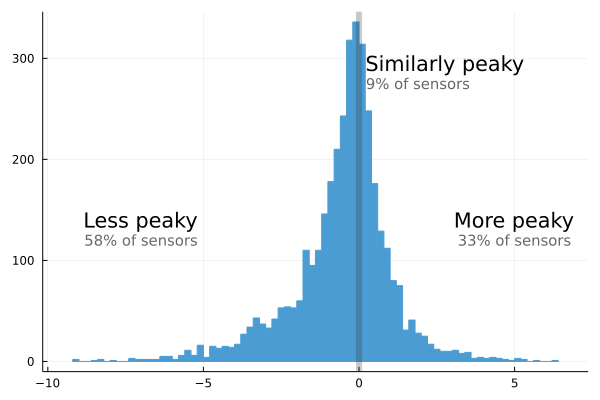

In [14]:
histogram(estdata.Δpeak_hour_occ * 100, legend=false, color=UNC_BLUE, line=UNC_BLUE)
vspan!([-0.1, 0.1], color=:gray20, opacity=0.25)
pct_less_peaky = mean(estdata.Δpeak_hour_occ .* 100 .< -0.1) * 100
pct_more_peaky = mean(estdata.Δpeak_hour_occ .* 100 .> 0.1) * 100
pct_similar = mean(abs.(estdata.Δpeak_hour_occ .* 100) .≤ 0.1) * 100
annotate!(-7, 140, text("Less peaky", pointsize=14))
annotate!(-7, 120, text("$(round(Int64, pct_less_peaky))% of sensors", pointsize=10, color=:gray40))

annotate!(5, 140, text("More peaky", pointsize=14))
annotate!(5, 120, text("$(round(Int64, pct_more_peaky))% of sensors", pointsize=10, color=:gray40))

annotate!(0.25, 295, text("Similarly peaky", pointsize=14, halign=:left))
annotate!(0.25, 275, text("$(round(Int64, pct_similar))% of sensors", pointsize=10, color=:gray40, halign=:left))
savefig("../fig/peakiness_change.pdf")
plot!()